_Dependencies and library requirements_

In [1]:
# standard libraries
import numpy as np #numpy warnings, if any, may be safely ignored, known issue.
import pandas as pd
from collections import defaultdict
from math import * # Used for the haversine/distance calculations

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for model building
from sklearn.cluster import KMeans

# for optimizations
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

_Loading in station data by year. Hierarchal dataframe with levels based on year_

In [2]:
nr_dict = defaultdict()
for x in [2010 + x for x in range(8)] :
    nr_dict[x] = pd.read_csv("https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/" \
                             +str(x)+"/NiceRide_station_"+str(x)+".csv")
nr_station = pd.concat(nr_dict)

_Due to station distance matrices being different sizes current load pattern is by manual selection of year._

In [3]:
dist_dict = defaultdict()
year = 2012
dist_dict[year] = pd.read_csv("https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/" \
                               +str(year)+"/distance_matrix_"+str(year)+".csv",index_col=0)
dist_station = pd.concat(dist_dict)
nr_station_temp = nr_station.loc[(year),:]
distance_matrix = dist_station.loc[(year),:]

_Plotting Square sums by N clusters. No distinct elbow presents itself any year. This is a sanity check_

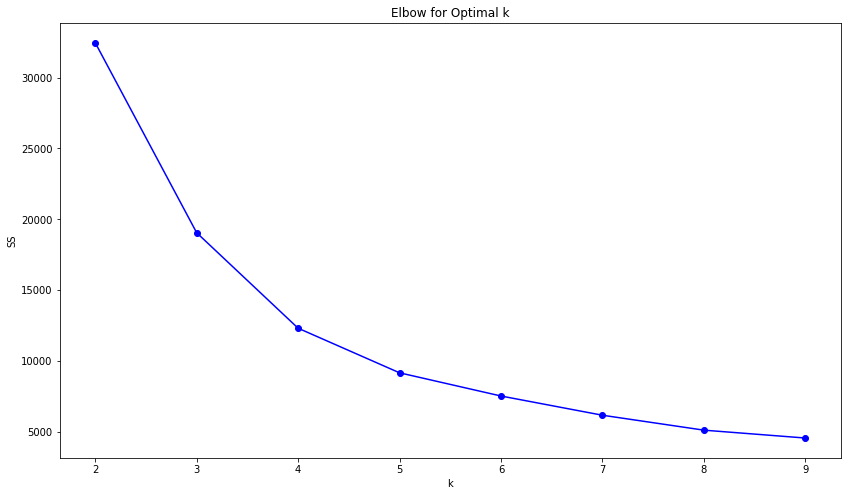

In [4]:
SS = []

# k means determine k
for k in range(2,10) :
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(distance_matrix)

    SS.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(14,8))
plt.plot(range(2,10), SS, 'bo-')
plt.xlabel('k')
plt.ylabel('SS')
plt.title('Elbow for Optimal k')
plt.show()

_Determining K cluster values by the silhoutte values. Values are shifted for values (structures) greater than 3_

In [11]:
avg_sil = []

#    Compute clustering algorithm (e.g., k-means clustering) for different values of k. For instance, by varying k from 1 to 10 clusters.
for k in range(2,11) :
    clusterer = KMeans(n_clusters=k, random_state=24)
    clusterer.fit(distance_matrix)
    cluster_labels = clusterer.labels_
    
#    For each k, calculate the average silhouette of observations (avg.sil).
    silhouette_avg = silhouette_score(distance_matrix, cluster_labels)
#    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)
    avg_sil.append(silhouette_avg)
    print(silhouette_avg)
#    The location of the maximum (local) is considered as the appropriate number of clusters.
k_value = avg_sil.index(max(avg_sil[4:10])) + 2

0.711400355057
0.637983748295
0.509742705762
0.487322731734
0.493413850024
0.485675783624
0.456251022987
0.412798894035
0.405158253516


In [6]:
pca_df = pd.DataFrame(PCA(n_components=2).fit_transform(distance_matrix), columns=['x','y'], index=nr_station_temp.index)
pca_df = pd.DataFrame(nr_station_temp.Terminal).join(pca_df)
    # Joins customer names to pca_df containing x-y PCA components

In [7]:
pca_df.head()

,Terminal,x,y
0,30000,-22.669773,-3.546372
1,30001,-5.913190,-12.208554
2,30002,-14.767206,-10.957678
3,30003,-24.835122,18.197907
4,30004,-27.367213,2.670838


In [8]:
def find_center(df, clus):
    
    max_l = df[df['cluster'] == clus]['Longitude'].max()
    min_l = df[df['cluster'] == clus]['Longitude'].min()
    center_long = (max_l - min_l)/2 + min_l
    
    max_w = df[df['cluster'] == clus]['Latitude'].max()
    min_w = df[df['cluster'] == clus]['Latitude'].min()
    center_lat = (max_w - min_w)/2 + min_w
    
    return (center_long, center_lat)

In [9]:
def circle_radius(df,clus):
    
    long1, lat1 = find_center(df,clus)
    
    lat2 = df[df['cluster'] == clus]['Latitude'].max()
    long2 = df[df['cluster'] == clus]['Longitude'].max()
    
    diff_long = long2-long1
    diff_lat = lat2-lat1
    if diff_lat > diff_long:
        return diff_lat
    else:
        return diff_long

_Graphing of the clusters by Latitude (X) and Longitude (Y). Included is the code for creating circles of influence. A subject measure of the area of cover the clusters would have for intra/trans travel. The 'circle' is based on square center of the cluster determined by lat/long and a radius that's based on the larger difference between max or min lat/long._

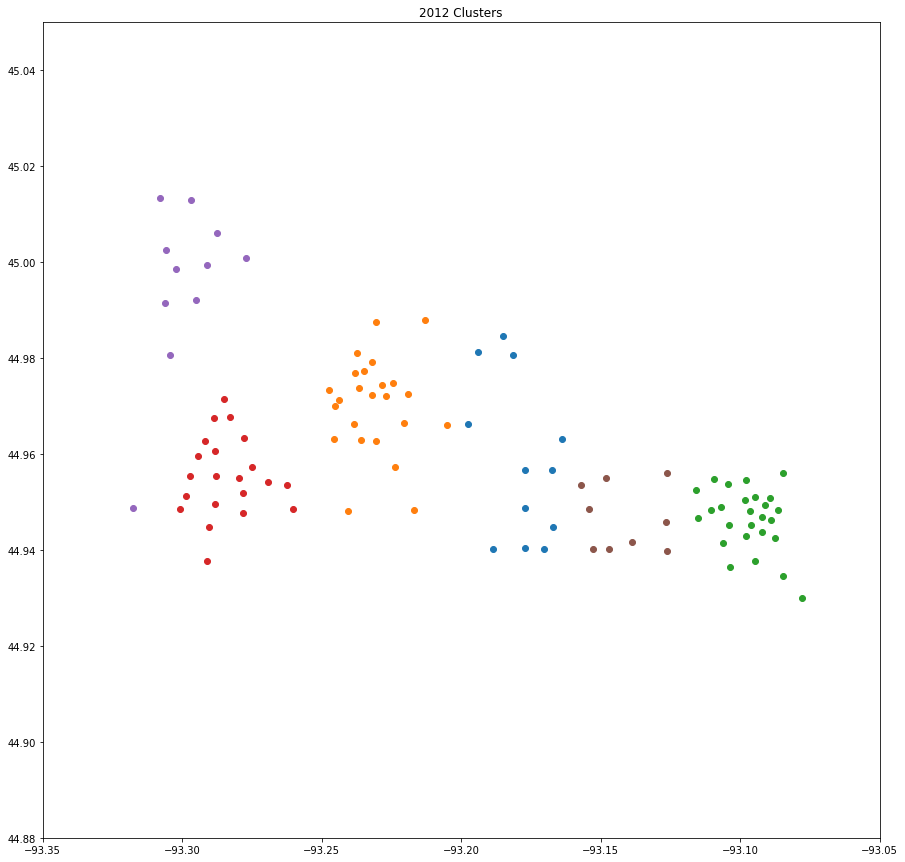

In [14]:
best_cluster = pd.merge(nr_station_temp, pca_df, left_on='Terminal', right_on='Terminal')
best_cluster['cluster']= KMeans(n_clusters=k_value, n_init=200).fit(distance_matrix).labels_

plt.figure(figsize=[15,15])
plt.xlim([-93.35,-93.05])
plt.ylim([44.88,45.05])

for k in range(0,k_value):
    # Plotting the 'Area of Influences based on cluster 'centers'
#    long,lat = find_center(best_cluster, k)
#    radius = circle_radius(best_cluster,k)
#    circle = plt.Circle((long,lat), radius, fill=False)
    
    temp = best_cluster[best_cluster.cluster == k]
    ax = plt.scatter(temp.Longitude, temp.Latitude)
    
    ax = plt.gca()
    ax.set_title(str(year)+' Clusters')

#    ax.cla
#    ax.plot(long,lat, marker='*', c='black') # Plotting cluster 'centers'
#    ax.add_artist(circle)
    
plt.show()
    

#plt.savefig("/home/gilmore/NiceRideMN/Visualizations/Clusters/"+str(year)+"_clustering")